In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from utils import *
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision.transforms import transforms

In [3]:
edges2shoes = '../data/edges2shoes/train/1_AB.jpg'
facades = '../data/facades/train/1.jpg'
cityscapes = '../data/cityscapes/train/1.jpg'
maps = '../data/maps/train/1.jpg'

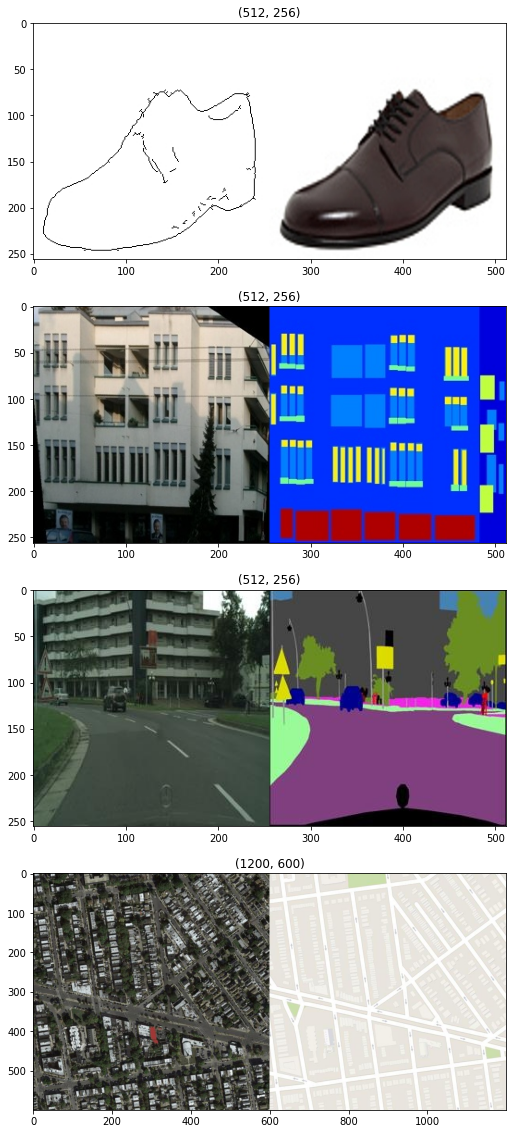

In [8]:
edges2shoes_img = Image.open(edges2shoes)
facades_img = Image.open(facades)
cityscapes_img = Image.open(cityscapes)
maps_img = Image.open(maps)

plt.figure(figsize=(40, 20))

plt.subplot(4, 1, 1)
plt.title(edges2shoes_img.size) #  W H
plt.imshow(edges2shoes_img)

plt.subplot(4, 1, 2)
plt.title(facades_img.size) #  W H
plt.imshow(facades_img)

plt.subplot(4, 1, 3)
plt.title(cityscapes_img.size) #  W H
plt.imshow(cityscapes_img)

plt.subplot(4, 1, 4)
plt.title(maps_img.size) #  W H
plt.imshow(maps_img)

plt.show()

In [14]:
class Pix2Pix_G(nn.Module):
  def __init__(self):
    super().__init__()

    # (B 256 256 64)
    self.down1 = CBR2d(in_channel=3, out_channel=64, norm=False) # (B 128 128 64)
    self.down2 = CBR2d(in_channel=64, out_channel=128) # (B 64 64 128)
    self.down3 = CBR2d(in_channel=128, out_channel=256) # (B 32 32 256)
    self.down4 = CBR2d(in_channel=256, out_channel=512) # (B 16 16 512)
    self.down5 = CBR2d(in_channel=512, out_channel=512) # (B 8 8 512)
    self.down6 = CBR2d(in_channel=512, out_channel=512) # (B 4 4 512)
    self.down7 = CBR2d(in_channel=512, out_channel=512) # (B 2 2 512)
    self.down8 = CBR2d(in_channel=512, out_channel=512, norm=False) # (B 1 1 512)

    self.up8 = DECBR2d(in_channel=512, out_channel=512, drop=True) # (B 2 2 512)
    self.up7 = DECBR2d(in_channel=1024, out_channel=512, drop=True) # (B 4 4 512) 
    self.up6 = DECBR2d(in_channel=1024, out_channel=512, drop=True) # (B 8 8 512)
    self.up5 = DECBR2d(in_channel=1024, out_channel=512) # (B 16 16 512)
    self.up4 = DECBR2d(in_channel=1024, out_channel=256) # (B 32 32 512)
    self.up3 = DECBR2d(in_channel=512, out_channel=128) # (B 64 64 128)
    self.up2 = DECBR2d(in_channel=256, out_channel=64) # (B 128 128 64)
    self.up1 = nn.ConvTranspose2d(
      in_channels=128,
      out_channels=3, 
      kernel_size=4, 
      padding=1, 
      stride=2
    ) # (B 256 256 3)


  def forward(self, x):
    down1 = self.down1(x)
    down2 = self.down2(down1)
    down3 = self.down3(down2)
    down4 = self.down4(down3)
    down5 = self.down5(down4)
    down6 = self.down6(down5)
    down7 = self.down7(down6)
    down8 = self.down8(down7)

    up8 = self.up8(down8)
    cat7 = torch.cat((up8, down7), dim=1)
    up7 = self.up7(cat7)
    cat6 = torch.cat((up7, down6), dim=1)
    up6 = self.up6(cat6)
    cat5 = torch.cat((up6, down5), dim=1)
    up5 = self.up5(cat5)
    cat4 = torch.cat((up5, down4), dim=1)
    up4 = self.up4(cat4)
    cat3 = torch.cat((up4, down3), dim=1)
    up3 = self.up3(cat3)
    cat2 = torch.cat((up3, down2), dim=1)
    up2 = self.up2(cat2)
    cat1 = torch.cat((up2, down1), dim=1)
    up1 = self.up1(cat1)

    return torch.tanh(up1)

In [15]:
from torchsummary import summary
model = Pix2Pix_G().cuda()
a = summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
             CBR2d-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
             CBR2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        LeakyReLU-10          [-1, 256, 32, 32]               0
            CBR2d-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class generator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(generator, self).__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        # self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

In [13]:
from torchsummary import summary
model = generator().cuda()
a = summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 51

c:\Users\BSH\.virtualenvs\study-Im21C8TV\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
